In [1]:
import mdtraj as md
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from numba import jit
import string
from scipy.ndimage import gaussian_filter1d
from mdtraj import element
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from scipy.optimize import least_squares
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
from matplotlib.colors import LogNorm
import warnings
import itertools
warnings.filterwarnings('ignore')
import MDAnalysis as mda
import MDAnalysis.analysis.msd as msd
from statsmodels.tsa.stattools import acf
import sys
#!git clone https://github.com/fpesceKU/BLOCKING.git
sys.path.append('BLOCKING')
from main import BlockAnalysis
from PIL import Image
import matplotlib.ticker as ticker

In [2]:
plt.rcParams['xtick.top'] = True      
plt.rcParams['ytick.right'] = True   
plt.rcParams['xtick.direction'] = 'in' 
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 9 

# FUSRRG-polyU40 large

In [3]:
"""
FUSRGG3-polyU40: 
slab simulation 
500 chains in [20,20,150]
"""

def get_fasta(protein):
    f = open('./data/fastabib.fasta', 'r')
    proteins = {}
    for line in f:
        if line[0]=='>':
            key=line[1:-1]
        else:
            fasta=line[:-1]
            proteins[key]=fasta
    f.close()
    return proteins[protein]

def get_protein_mass(fasta):
    f = './data/residues.csv'
    residues = pd.read_csv(f).set_index('one')
    masses = []
    for a in list(fasta):
        if a in ['a','u','r']: # for RNA
            masses.append(residues.loc['p','MW'])
            masses.append(residues.loc[a,'MW'])
        else:
            masses.append(residues.loc[a,'MW'])
    masses[0] += 1
    masses[-1] += 17
    return np.array(masses)

def get_mass_concentration_simulate(Ls,protein,n_chain,temp):
    V = Ls[0]*Ls[1]*Ls[2] # nm**3
    #print(get_protein_mass(get_fasta(protein)).shape)
    mass = np.sum(get_protein_mass(get_fasta(protein)))
    conv = 1/6.02*10**1 # in mg/mL    
    lo = n_chain*mass/V*conv
    return lo


def get_mol_concentration(n_chain,Ls):
    V = Ls[0]*Ls[1]*Ls[2]
    conv = 10**7/6.022 # in micro-M
    lo = n_chain/V*conv    
    return lo 



In [4]:
FUSRGG3 = 500
polyU40 = [40,80,100,110,120,130,140,160,200] #[5,10,20,40,80,100,120,130,140,160,200,320,500,550]
labels = []
mass_pro = []
mass_rna = []
ratio_rna_pro = []
box = []
ref=[]
for nu in polyU40:
    Ls = [20,20,150]
    labels.append('FUSRGG3({:d})/polyU40({:d})'.format(FUSRGG3,nu))
    cpro = get_mass_concentration_simulate(Ls,'FUSRGG3',FUSRGG3,300)
    crna = get_mass_concentration_simulate(Ls,'polyU40',nu,300)
    mass_pro.append(cpro)
    mass_rna.append(crna)
    ratio_rna_pro.append(crna/cpro)
    box.append( "["+str(Ls[0])+","+str(Ls[1])+","+str(Ls[2])+"]" )
    ref.append('Kaur et al.')
data = {'Name': labels, 'Protein conc. [mg/ml]':mass_pro, 
        'RNA conc. [mg/ml]':mass_rna, 'RNA/Protein ratio':ratio_rna_pro,
        'Box length [nm]': box, 'Ref.':ref}
df_5 = pd.DataFrame(data)
df_5

,Name,Protein conc. [mg/ml],RNA conc. [mg/ml],RNA/Protein ratio,Box length [nm],Ref.
0,FUSRGG3(500)/polyU40(40),48.057863,14.212625,0.295740,"[20,20,150]",Kaur et al.
1,FUSRGG3(500)/polyU40(80),48.057863,28.425249,0.591480,"[20,20,150]",Kaur et al.
2,FUSRGG3(500)/polyU40(100),48.057863,35.531561,0.739350,"[20,20,150]",Kaur et al.
3,FUSRGG3(500)/polyU40(110),48.057863,39.084718,0.813285,"[20,20,150]",Kaur et al.
4,FUSRGG3(500)/polyU40(120),48.057863,42.637874,0.887220,"[20,20,150]",Kaur et al.
5,FUSRGG3(500)/polyU40(130),48.057863,46.191030,0.961154,"[20,20,150]",Kaur et al.
6,FUSRGG3(500)/polyU40(140),48.057863,49.744186,1.035089,"[20,20,150]",Kaur et al.
7,FUSRGG3(500)/polyU40(160),48.057863,56.850498,1.182959,"[20,20,150]",Kaur et al.
8,FUSRGG3(500)/polyU40(200),48.057863,71.063123,1.478699,"[20,20,150]",Kaur et al.


# Analysis of slab simulation, FUSRGG3-polyU40

In [5]:
def get_csat(z,h):
    """Function to calculate csat and ccon from concentration profiles"""
    lz = h.shape[1]+1
    edges = np.arange(-lz/2.,lz/2.,1)/10 # bin 0.1 nm
    dz = (edges[1]-edges[0])/2.
    z = edges[:-1]+dz
    profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
    residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
    hm = np.mean(h,axis=0)
    z1 = z[z>0]
    h1 = hm[z>0]
    z2 = z[z<0]
    h2 = hm[z<0]
    p0=[1,1,1,1]
    res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[100]*4))
    res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[100]*4))

    cutoffs1 = [res1.x[2]-res1.x[3],-res2.x[2]+res2.x[3]]
    cutoffs2 = [res1.x[2]+8*res1.x[3],-res2.x[2]-8*res2.x[3]]

    bool1 = np.logical_and(z<cutoffs1[0],z>cutoffs1[1])
    bool2 = np.logical_or(z>cutoffs2[0],z<cutoffs2[1])

    dilarray = np.apply_along_axis(lambda a: a[bool2].mean(), 1, h)
    denarray = np.apply_along_axis(lambda a: a[bool1].mean(), 1, h)

    dil = hm[bool2].mean()
    den = hm[bool1].mean()

    block_dil = BlockAnalysis(dilarray)
    block_den = BlockAnalysis(denarray)
    block_dil.SEM()
    block_den.SEM()
    return z,h,block_dil.av, block_dil.sem, block_den.av, block_den.sem

        
def hist_comp(name, atom_indices, n_seq,temp=293):
    trj = md.load('./analyze_protein-rna/traj/{:s}_{:d}.dcd'.format(name,temp),
                  top='./analyze_protein-rna/traj/{:s}_{:d}.pdb'.format(name,temp),atom_indices= atom_indices)
    z0 = trj.unitcell_lengths[0,2]
    zs = np.arange(0,z0,1) # bin size 1 nm
    pos = trj.xyz
    
    ns = []
    for t in range(trj.n_frames):
        n,_ = np.histogram(pos[t,:,2],bins=zs)
        ns.append(n)
    ns = np.array(ns)
    L = trj.unitcell_lengths[0,0]
    N = n_seq
    dLz = zs[1]-zs[0] 
    conv = 10/6.022/N/L/L/dLz*1e3 # in mM #conv = 100/6.022/N/L/L*1e3 # in mM
    xs = 0.5*(zs[1:]+zs[:-1]) 
    return xs, ns*conv

In [6]:
slab_conc = {40:[48.057863, 14.212625],
            80:[48.057863,28.425249],
             100:[48.057863,35.531561],
             110:[48.057863,39.084718],
             120:[48.057863,42.637874],
             130:[48.057863,46.191030],
             140:[48.057863,49.744186],
             160:[48.057863,56.850498],
             200:[48.057863,71.063123]} # key is number of RNA and list is [proein, RNA]. unit in mg/ml

# Compare cutoff 6 and cutoff 4

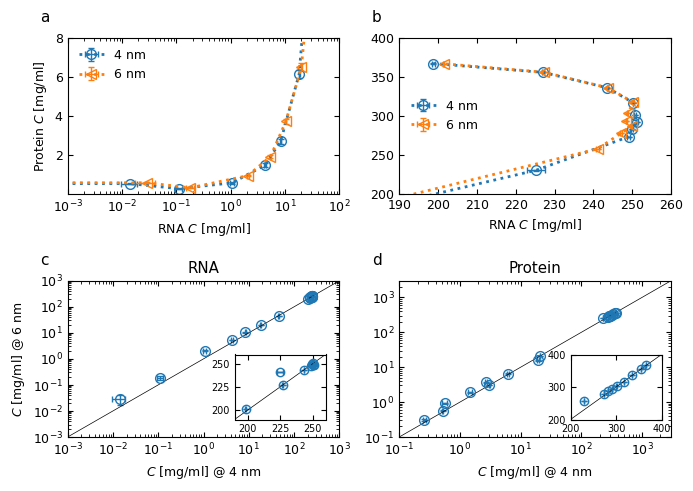

In [7]:
# compare cutoff 6 and cutoff 4
RRP_seq = 34
RRP_n  = 500
RNA_seq = 40
pro_mass =  3471.7 * 1e-3
rna_mass = 12834 * 1e-3


def call_values(fn):
    data = np.load(fn)
    [csat, csat_err, cden, cden_err] = data[0].tolist()
    [csat_r, csat_err_r, cden_r, cden_err_r] = data[1].tolist() 
    
    pros = [[csat,csat_err],[cden,cden_err_r]]
    rnas = [[csat_r,csat_err_r],[cden_r,cden_err_r]]
    return pros, rnas 
    
    
fig, ax = plt.subplots(2,2,figsize=(7,5))
cmap = plt.get_cmap("tab10")

x0s,y0s = [],[] # 4 nm
x1s,y1s = [],[] # 6 nm
for ind,n_rna in enumerate([40,80,100,110,120,130,140,160,200]):    
    
    x0,y0 =  call_values("./data/view2/conc_RRP{:d}_RNA{:d}.npy".format(RRP_n, n_rna))
    x0s += x0
    y0s += y0
    
    x1,y1 =  call_values("./data/view2/RRP{:d}_RNA{:d}_cutoff6.npy".format(RRP_n, n_rna))
    x1s += x1
    y1s += y1


sortids = [0,2,4,6,8,10,12,14,16,17,15,13,11,9,7,5,3,1]
x0s,y0s = np.array(x0s)[sortids]*pro_mass,np.array(y0s)[sortids]*rna_mass # 4 nm
x1s,y1s = np.array(x1s)[sortids]*pro_mass,np.array(y1s)[sortids]*rna_mass # 6 nm
    
    

ax[0,0].errorbar(y0s[:,0], x0s[:,0], xerr=y0s[:,1], yerr=x0s[:,1], linestyle="dotted", label="4 nm"
                 ,marker='o', lw=2, ms=7, elinewidth=1, capsize=2, capthick=1,color=cmap(0), markerfacecolor="none")
ax[0,0].errorbar(y1s[:,0], x1s[:,0], xerr=y1s[:,1], yerr=x1s[:,1], linestyle="dotted", label="6 nm"
                 ,marker='<', lw=2, ms=7, elinewidth=1, capsize=2, capthick=1,color=cmap(1), markerfacecolor="none")

ax[0,1].errorbar(y0s[:,0], x0s[:,0], xerr=y0s[:,1], yerr=x0s[:,1], linestyle="dotted", label="4 nm"
                 ,marker='o', lw=2, ms=7, elinewidth=1, capsize=2, capthick=1,color=cmap(0), markerfacecolor="none")
ax[0,1].errorbar(y1s[:,0], x1s[:,0], xerr=y1s[:,1], yerr=x1s[:,1], linestyle="dotted", label="6 nm"
                 ,marker='<', lw=2, ms=7, elinewidth=1, capsize=2, capthick=1,color=cmap(1), markerfacecolor="none")

ax[1,0].errorbar(y0s[:,0], y1s[:,0], xerr=y0s[:,1], yerr=y1s[:,1], linestyle="dotted"
                 ,marker='o', lw=0, ms=7, elinewidth=1, capsize=2, capthick=1, markerfacecolor="none")
ax[1,1].errorbar(x0s[:,0], x1s[:,0], xerr=x0s[:,1], yerr=x1s[:,1], linestyle="dotted"
                 ,marker='o', lw=0, ms=7, elinewidth=1, capsize=2, capthick=1, markerfacecolor="none")

ax[0,0].legend(frameon=False)
ax[0,0].set_ylabel("Protein $C$ [mg/ml]")
ax[0,0].set_xlabel("RNA $C$ [mg/ml]")
ax[0,0].set_xlim([0.001,100])
ax[0,0].set_ylim([0.001,8])
ax[0,0].set_xscale("log")

ax[0,1].legend(frameon=False)
#ax[0,1].set_ylabel("Protein: $C$ [mg/ml]")
ax[0,1].set_xlabel("RNA $C$ [mg/ml]")
ax[0,1].set_xlim([190,260])
ax[0,1].set_ylim([200,400])


ax[1,0].plot([0.001,1000],[0.001,1000],color="k",linewidth=0.5)
ax[1,0].set_title("RNA")
ax[1,0].set_xlabel("$C$ [mg/ml] @ 4 nm")
ax[1,0].set_ylabel("$C$ [mg/ml] @ 6 nm")
ax[1,0].set_xlim([0.001,1000])
ax[1,0].set_ylim([0.001,1000])
ax[1,0].set_xscale("log")
ax[1,0].set_yscale("log")

ax[1,1].plot([0.01,3000],[0.01,3000],color="k",linewidth=0.5)
ax[1,1].set_title("Protein")
ax[1,1].set_xlabel("$C$ [mg/ml] @ 4 nm")
#ax[1,1].set_ylabel("$C$ [mg/ml] @6 nm")
ax[1,1].set_xlim([0.1,3*1000])
ax[1,1].set_ylim([0.1,3*1000])
ax[1,1].set_xscale("log")
ax[1,1].set_yscale("log")

ax1 = fig.add_axes((0.34, 0.15, 0.13,0.13))
ax1.errorbar(y0s[:,0], y1s[:,0], xerr=y0s[:,1], yerr=y1s[:,1], linestyle="dotted"
                 ,marker='o', lw=0, ms=6, elinewidth=1, capsize=2, capthick=1, markerfacecolor="none")
ax1.plot([0.001,1000],[0.001,1000],color="k",linewidth=0.5)
ax1.set_xlim([190,260])
ax1.set_ylim([190,260])
ax1.tick_params(direction='in',labelsize=7)
#ax1.set_xscale("log")
#ax1.set_yscale("log")

ax2 = fig.add_axes((0.82, 0.15, 0.13,0.13))
ax2.errorbar(x0s[:,0], x1s[:,0], xerr=x0s[:,1], yerr=x1s[:,1], linestyle="dotted"
                 ,marker='o', lw=0, ms=6, elinewidth=1, capsize=2, capthick=1, markerfacecolor="none")
ax2.plot([0.001,1000],[0.001,1000],color="k",linewidth=0.5)
ax2.set_xlim([200,400])
ax2.set_ylim([200,400])
ax2.tick_params(direction='in',labelsize=7)


ax[0,0].text(-0.1,1.1,"a",fontsize=11,transform=ax[0,0].transAxes) 
ax[0,1].text(-0.1,1.1,"b",fontsize=11,transform=ax[0,1].transAxes) 
ax[1,0].text(-0.1,1.1,"c",fontsize=11,transform=ax[1,0].transAxes) 
ax[1,1].text(-0.1,1.1,"d",fontsize=11,transform=ax[1,1].transAxes) 


plt.tight_layout()
plt.savefig("cutoff_fus-rna.pdf",dpi=300,bbox_inches='tight')
plt.savefig("cutoff_fus-rna.png",dpi=300,bbox_inches='tight')
plt.show()

## save density data (4 nm)

In [8]:
systems = []
cden_list_pro = []
cden_list_rna = []

RRP_seq = 34
RRP_n  = 500
RNA_seq = 40

for ind,n_rna in enumerate([40,80,100,110,120,130,140,160,200]):
    data = np.load("./data/view2/conc_RRP{:d}_RNA{:d}.npy".format(RRP_n, n_rna))
    [csat, csat_err, cden, cden_err] = data[0].tolist()
    [csat_r, csat_err_r, cden_r, cden_err_r] = data[1].tolist() 

    cden_list_pro.append("{:f}±{:f}".format(cden, cden_err))
    cden_list_rna.append("{:f}±{:f}".format(cden_r, cden_err_r))
    systems.append("FUSRGG3({:d}), polyU40({:d})".format(RRP_n,n_rna))
    
    df = pd.DataFrame( {"system": systems,
                                   "$C^{P}$[μM]": cden_list_pro,
                                   "$C^{R}$[μM]": cden_list_rna} )
display(df)
df.to_csv('./data/fusrgg3_polyU40_cdens.csv')

,system,$C^{P}$[μM],$C^{R}$[μM]
0,"FUSRGG3(500), polyU40(40)",105.621114±0.172427,15.488060±0.031727
1,"FUSRGG3(500), polyU40(80)",102.363574±0.076296,17.687490±0.015780
2,"FUSRGG3(500), polyU40(100)",96.669896±0.023887,18.980953±0.004652
3,"FUSRGG3(500), polyU40(110)",91.181232±0.028454,19.498354±0.006220
4,"FUSRGG3(500), polyU40(120)",86.729563±0.085947,19.532360±0.015273
5,"FUSRGG3(500), polyU40(130)",84.021419±0.131174,19.568440±0.018626
6,"FUSRGG3(500), polyU40(140)",81.563980±0.127359,19.471508±0.021092
7,"FUSRGG3(500), polyU40(160)",78.620104±0.166918,19.408533±0.024110
8,"FUSRGG3(500), polyU40(200)",66.266520±0.818105,17.548118±0.179322


# FUSRGG3-PLP-polyU40

(299,)


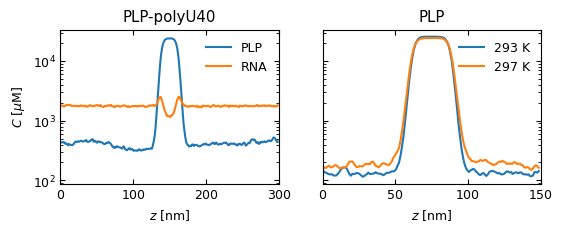

In [9]:
fig, ax = plt.subplots(1,2,figsize=(6.2,2), sharey=True)

PLP_seq = 173
PLP_n = 164
RNA_seq = 40
n_rna = 128

[x1,y1] = np.load("./data/view2/PLP_PLP-{:d}_polyR40-{:d}_slab.npy".format(PLP_n,n_rna))  
print(y1.shape)
ax[0].plot(x1,y1*1e3,label="PLP") #,color=cmap(ind))

[x2,y2] = np.load("./data/view2/RNA_PLP-{:d}_polyR40-{:d}_slab.npy".format(PLP_n,n_rna))
ax[0].plot(x2,y2*1e3,label="RNA")

ax[0].set_xlabel("$z$ [nm]")
ax[0].set_ylabel("$C$ [$\mu$M]")
ax[0].set_yscale("log")
ax[0].legend(frameon=False)
ax[0].set_xlim([0,300])
ax[0].set_title("PLP-polyU40")


"""
PLP only
"""
name = 'PLP_slab'
PLP_seq = 173
PLP_n = 164


[x3,y3] = np.load("./data/view2/PLP_PLP-{:d}_slab.npy".format(PLP_n))
ax[1].plot(x3,y3*1e3,label="293 K") #,color=cmap(ind))

[x3,y3] = np.load("./data/view2/PLP_PLP-{:d}_slab_297.npy".format(PLP_n))
ax[1].plot(x3,y3*1e3,label="297 K") #,color=cmap(ind))

ax[1].set_xlabel("$z$ [nm]")
ax[1].set_title("PLP")
ax[1].set_yscale("log")
ax[1].set_xlim([0,150])
ax[1].legend(frameon=False)

plt.savefig("plp_ployU40.pdf",dpi=300,bbox_inches='tight')
plt.show()


### Cubic simulation

In [10]:
def hist_comp_sphere(name, atom_indices, n_seq):
    trj = md.load('./analyze_protein-rna/traj/{:s}_293.dcd'.format(name),top='./analyze_protein-rna/traj/{:s}_293.pdb'.format(name),
                   atom_indices= atom_indices)
        
    r0 = trj.unitcell_lengths[0,2]
    #print(r0)
    rs = np.arange(0,r0/2,1)#rs = np.arange(0,r0/2,0.1)
    pos = trj.xyz
    center = np.array([r0/2,r0/2,r0/2])
    pos = np.linalg.norm(pos-center,axis=-1)
    
    ns = []
    for t in range(trj.n_frames):
        n,_ = np.histogram(pos[t,:],bins=rs)
        ns.append(n)
    ns = np.array(ns)
    N = n_seq
    xs = 0.5*(rs[1:]+rs[:-1])
    A = 4*np.pi*np.square(xs)
    dr = rs[1]-rs[0]
    conv = 10/6.022/N/A/dr*1e3 # in mM 
    return xs, ns*conv

# Figure 3

In [11]:
plt.rc('font', family='Arial')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['font.size'] = 8 
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['xtick.top'] = True  
plt.rcParams['ytick.right'] = True 
cmap = plt.get_cmap("tab10")
from PIL import Image

def error_prop(x,y,ex,ey):
    # error propergation
    return np.sqrt( (1/y*ex)**2 + (x/y/y*ey)**2 )

40 dilute, molar 0.0
40 dilute, mass 0.0
tie line in molar 0.15532632019815906
tie line in mass 0.5742022621260977
80 dilute, molar 0.0
80 dilute, mass 0.0
tie line in molar 0.17427903080674914
tie line in mass 0.6442656569904711
100 dilute, molar 0.007343989398150644
100 dilute, mass 0.027148878052788362
tie line in molar 0.19663936078486416
tie line in mass 0.7269261619128804
110 dilute, molar 0.11600498328105964
110 dilute, mass 0.4288411888783937
tie line in molar 0.21392196180060596
tie line in mass 0.7908155824953126
120 dilute, molar 0.5152544448253907
120 dilute, mass 1.9047658337094404
tie line in molar 0.2246703763675492
tie line in mass 0.8305497624509971
130 dilute, molar 0.785353861928674
130 dilute, mass 2.903255311228678
tie line in molar 0.23013041614912513
tie line in mass 0.8507341535437601
140 dilute, molar 0.8348316287617914
140 dilute, mass 3.0861621463631157
tie line in molar 0.23301009723914684
tie line in mass 0.8613796088277242
160 dilute, molar 0.8032281684176

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


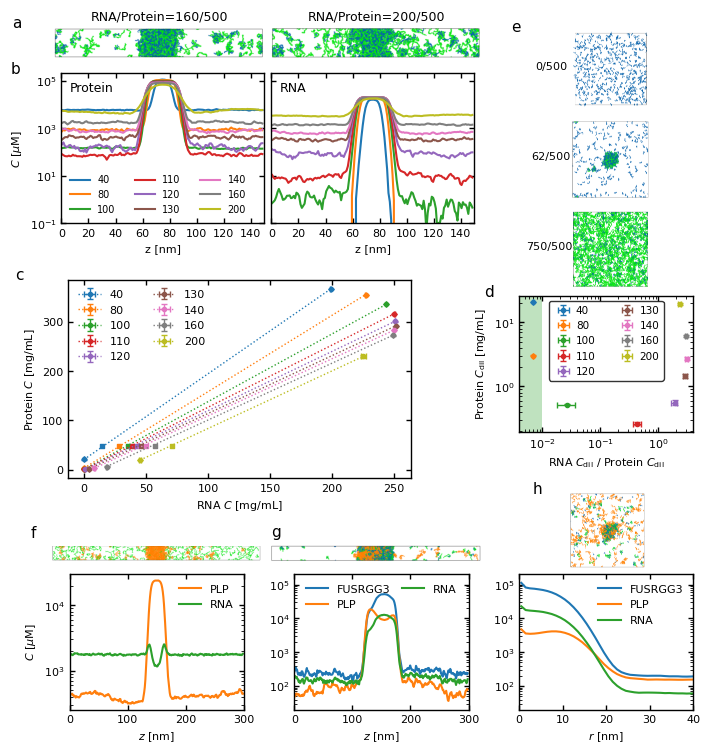

In [12]:
# With lower limit

n_fig = 1
fig = plt.figure(figsize=(7*n_fig,7.5*n_fig))
ax0 = plt.subplot2grid( (8,6), (0,0), rowspan=1, colspan=2 )
ax1 = plt.subplot2grid( (8,6), (0,2), rowspan=1, colspan=2 )
ax2 = plt.subplot2grid( (8,6), (1,0), rowspan=2, colspan=2 )
ax3 = plt.subplot2grid( (8,6), (1,2), rowspan=2, colspan=2, sharey=ax2 )
ax4 = plt.subplot2grid( (8,6), (3,0), rowspan=2, colspan=4 )
ax5 = plt.subplot2grid( (8,6), (3,4), rowspan=2, colspan=2 )

ax6 = plt.subplot2grid( (8,6), (0,4), rowspan=1, colspan=2 )
ax7 = plt.subplot2grid( (8,6), (1,4), rowspan=1, colspan=2 )
ax8 = plt.subplot2grid( (8,6), (2,4), rowspan=1, colspan=2 )

ax9 = plt.subplot2grid( (8,6), (5,0),  rowspan=1, colspan=2 )
ax10 = plt.subplot2grid( (8,6), (6,0), rowspan=2, colspan=2 )
ax11 = plt.subplot2grid( (8,6), (5,2), rowspan=1, colspan=2 )
ax12 = plt.subplot2grid( (8,6), (6,2), rowspan=2, colspan=2 )
ax13 = plt.subplot2grid( (8,6), (5,4), rowspan=1, colspan=2 )
ax14 = plt.subplot2grid( (8,6), (6,4), rowspan=2, colspan=2 )

ax0.axis('off')
ax0 = fig.add_axes((0.06,0.88,0.3,0.14))
ax0.axis("off")
ax0.imshow(Image.open("./data/view2_fig_snapshot/FUSRGG500_RNA160.png"))
ax0.set_title("RNA/Protein=160/500",fontsize=9)

ax1.axis('off')
ax1 = fig.add_axes((0.37,0.88,0.3,0.14))
ax1.axis("off")
ax1.imshow(Image.open("./data/view2_fig_snapshot/FUSRGG500_RNA200.png")) 
ax1.set_title("RNA/Protein=200/500",fontsize=9)

RRP_seq = 34
RRP_n  = 500
RNA_seq = 40
cmap = plt.get_cmap("tab10")

ax2.axis('off')
ax2 = fig.add_axes((0.07,0.66,0.29,0.25))
for ind,n_rna in enumerate([40,80,100,110,120,130,140,160,200]):
    data = np.load("./data/view2/PRO_FUSRGG3-500_polyR40-{:d}.npy".format(n_rna))
    ax2.plot(data[0],data[1]*1e3,label=n_rna,color=cmap(ind))
ax2.legend(frameon=False,ncol=3,fontsize=7)
ax2.set_xlabel("z [nm]")
ax2.set_ylabel("$C$ [$\mu$M]")
ax2.text(0.04,0.88,"Protein", size=9, transform=ax2.transAxes)
ax2.set_yscale("log")
ax2.set_ylim([1e-1, 2*1e5])
ax2.set_xlim([0, 150])
ax2.set_xticks(np.arange(0,150,20))

ax3.axis('off')
ax3 = fig.add_axes((0.37,0.66,0.29,0.25))
for ind,n_rna in enumerate([40,80,100,110,120,130,140,160,200]):
    data = np.load("./data/view2/RNA_FUSRGG3-500_polyR40-{:d}.npy".format(n_rna))
    ax3.plot(data[0],data[1]*1e3,label=n_rna,color=cmap(ind))
#ax3.legend(frameon=False,ncol=3)
ax3.set_xlabel("z [nm]")
#ax3.set_ylabel("$C$ [$\mu$M]")
ax3.text(0.04,0.88,"RNA", size=9, transform=ax3.transAxes)
ax3.set_yscale("log")   
ax3.tick_params('y', labelleft=False)
ax3.set_ylim([1e-1, 2*1e5])
ax3.set_xlim([0, 150])
ax3.set_xticks(np.arange(0,150,20))

#################################
slab_conc = {40:[48.057863, 14.212625],
            80:[48.057863,28.425249],
             100:[48.057863,35.531561],
             110:[48.057863,39.084718],
             120:[48.057863,42.637874],
             130:[48.057863,46.191030],
             140:[48.057863,49.744186],
             160:[48.057863,56.850498],
             200:[48.057863,71.063123]} # key is number of RNA and list is [proein, RNA]. unit in mg/ml

pro_mass =  3471.7 * 1e-3
rna_mass = 12834 * 1e-3

ax4.axis('off')
ax4 = fig.add_axes((0.08,0.35,0.54,0.265))
for ind,n_rna in enumerate([40,80,100,110,120,130,140,160,200]):
    data = np.load("./data/view2/RRP{:d}_RNA{:d}.npy".format(RRP_n, n_rna))
    [csat, csat_err, cden, cden_err] = data[0].tolist()
    [csat_r, csat_err_r, cden_r, cden_err_r] = data[1].tolist() 
    pros = np.array([csat,cden])
    rnas = np.array([csat_r,cden_r])
    pro_errs = np.array([csat_err,cden_err])
    rna_errs = np.array([csat_err_r, cden_err_r])

    ax4.errorbar(rnas*rna_mass, pros*pro_mass, xerr=rna_errs*rna_mass, yerr=pro_errs*pro_mass, label=n_rna, linestyle="dotted"
                ,marker='o', lw=1, ms=3, elinewidth=1, capsize=2, capthick=1,color=cmap(ind))
    [slab_pro,slab_rna] = slab_conc[n_rna] 
    ax4.scatter(slab_rna,slab_pro,marker="s",color=cmap(ind),s=5)
    
    ratio_err = error_prop(rnas[0]*rna_mass,pros[0]*pro_mass,rna_errs[0]*rna_mass,pro_errs[0]*pro_mass)
    if rnas[0]*1e3>1:
        ax5.errorbar(rnas[0]*rna_mass/(pros[0]*pro_mass), pros[0]*pro_mass, xerr=ratio_err ,yerr=pro_errs[0]*pro_mass, label=n_rna,
                     marker='o', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1,color=cmap(ind))
    else:
        ax5.errorbar(7*1e-3, pros[0]*pro_mass, xerr=ratio_err ,yerr=pro_errs[0]*pro_mass, label=n_rna,
                     marker='o', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1,color=cmap(ind))
    print(n_rna,"dilute, molar",rnas[0]/(pros[0]))
    print(n_rna,"dilute, mass",rnas[0]*rna_mass/(pros[0]*pro_mass))
    print("tie line in molar",(rnas[1]-rnas[0])/(pros[1]-pros[0]))
    print("tie line in mass",(rnas[1]-rnas[0])*rna_mass/(pros[1]-pros[0])/pro_mass)
    print("="*50)
    
ax4.legend(frameon=False,ncol=2,fontsize=8)
ax4.set_ylabel("Protein $C$ [mg/mL]") #ax4.set_ylabel("Protein: $C$ [$\mu$M]")
ax4.set_xlabel("RNA $C$ [mg/mL]") #ax4.set_xlabel("RNA: $C$ [$\mu$M]")

ax5.legend(ncol=2,frameon=True,fontsize=7.5,handletextpad=0.2,edgecolor='black')
ax5.set_ylabel("Protein $C_{\mathrm{dil}}$ [mg/mL]")
ax5.set_xlabel("RNA $C_{\mathrm{dil}}$ / Protein $C_{\mathrm{dil}}$")
ax5.set_xscale("log")
ax5.set_yscale("log")
ax5.set_xlim([4e-3,4])
ax5.axvspan(4e-3, 1e-2, facecolor=cmap(2), alpha=0.3)

ax6.axis('off')
ax6 = fig.add_axes((0.8,0.86,0.11,0.11))
ax6.axis("off")
ax6.imshow(Image.open("./data/view2_fig_snapshot/FUSRGG-500.png")) 
ax6.text(-0.48,0.5,"0/500",transform=ax6.transAxes,size=8)

ax7.axis('off')
ax7 = fig.add_axes((0.8,0.74,0.11,0.11))
ax7.axis("off")
ax7.imshow(Image.open("./data/view2_fig_snapshot/FUSRGG-500_polyR40_62.png")) 
ax7.text(-0.54,0.5,"62/500",transform=ax7.transAxes,size=8)

ax8.axis('off')
ax8 = fig.add_axes((0.8,0.62,0.11,0.11))
ax8.axis("off")
ax8.imshow(Image.open("./data/view2_fig_snapshot/FUSRGG-500_polyR40_750.png")) 
ax8.text(-0.6,0.5,"750/500",transform=ax8.transAxes,size=8)

##########################
PLP_seq = 173
PLP_n = 164
RNA_seq = 40
n_rna = 128

ax9.axis("off")
ax9 = fig.add_axes((0.055,0.22,0.3,0.1))
ax9.axis("off")
ax9.imshow(Image.open("./data/view2_fig_snapshot/PLP_RNA.png")) 

data = np.load("./data/view2/PLP_PLP-{:d}_polyR40-{:d}_slab.npy".format(PLP_n,n_rna))
ax10.plot(data[0],data[1]*1e3,label="PLP",color=cmap(1))
data = np.load("./data/view2/RNA_PLP-{:d}_polyR40-{:d}_slab.npy".format(PLP_n,n_rna))
ax10.plot(data[0],data[1]*1e3,label="RNA",color=cmap(2))
ax10.set_xlim([0, 300])

ax10.set_xlabel("$z$ [nm]")
ax10.set_ylabel("$C$ [$\mu$M]")
ax10.set_yscale("log")
ax10.legend(frameon=False)

###########################
RRP_seq = 34
RRP_n = 473
PLP_seq = 173
PLP_n = 164
RNA_seq = 40
n_rna = 128

ax11.axis("off")
ax11 = fig.add_axes((0.37,0.22,0.3,0.1))
ax11.axis("off")
ax11.imshow(Image.open("./data/view2_fig_snapshot/FUSRGG_PLP_RNA.png"))
                              
data = np.load("./data/view2/RRP_FUSRGG3-{:d}_PLP-{:d}_polyR40-{:d}_slab.npy".format(RRP_n,PLP_n,n_rna))
ax12.plot(data[0],data[1]*1e3,label="FUSRGG3")
data = np.load("./data/view2/PLP_FUSRGG3-{:d}_PLP-{:d}_polyR40-{:d}_slab.npy".format(RRP_n,PLP_n,n_rna))
ax12.plot(data[0],data[1]*1e3,label="PLP")
data = np.load("./data/view2/RNA_FUSRGG3-{:d}_PLP-{:d}_polyR40-{:d}_slab.npy".format(RRP_n,PLP_n,n_rna))
ax12.plot(data[0],data[1]*1e3,label="RNA")

ax12.set_xlabel("$z$ [nm]")
ax12.set_yscale("log")
ax12.legend(frameon=False,ncol=2,loc='upper center',columnspacing=1.)
ax12.set_ylim([2*1e1, 2*1e5])
ax12.set_xlim([0, 300])

###########################
RRP_seq = 34
RRP_n  = 473
PLP_seq = 173
PLP_n = 164
RNA_seq = 40
n_rna = 128

ax13.axis("off")
ax13 = fig.add_axes((0.7,0.25,0.3,0.1))
ax13.axis("off")
ax13.imshow(Image.open("./data/view2_fig_snapshot/FUSRGG_PLP_RNA_cubic.png"))
data = np.load("./data/view2/RRP_FUSRGG3-{:d}_PLP-{:d}_polyR40-{:d}.npy".format(RRP_n,PLP_n,n_rna))

ax14.plot(data[0],data[1]*1e3,label="FUSRGG3")
data = np.load("./data/view2/PLP_FUSRGG3-{:d}_PLP-{:d}_polyR40-{:d}.npy".format(RRP_n,PLP_n,n_rna))
ax14.plot(data[0],data[1]*1e3,label="PLP")
data = np.load("./data/view2/RNA_FUSRGG3-{:d}_PLP-{:d}_polyR40-{:d}.npy".format(RRP_n,PLP_n,n_rna))
ax14.plot(data[0],data[1]*1e3,label="RNA")
ax14.set_ylim([2*1e1, 2*1e5])

ax14.set_xlabel("$r$ [nm]")
ax14.set_xlim([0,40])
#ax14.set_ylabel("$C$ [$\mu$M]")
ax14.set_yscale("log")
ax14.legend(frameon=False)

ax0.text(-0.2,1.,"a",transform=ax0.transAxes,size=11)
ax2.text(-0.25,1.,"b",transform=ax2.transAxes,size=11)
ax4.text(-0.155,1,"c",transform=ax4.transAxes,size=11)
ax5.text(-0.2,1,"d",transform=ax5.transAxes,size=11)
ax6.text(-0.8,1.,"e",transform=ax6.transAxes,size=11)
ax9.text(-0.095,1.5,"f",transform=ax9.transAxes,size=11)
ax11.text(-0.,1.5,"g",transform=ax11.transAxes,size=11)
ax13.text(-0.5,1.,"h",transform=ax13.transAxes,size=11)

plt.tight_layout(w_pad=0.5)

for ax__ in [ax2,ax3]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0, pos1.y0+0.05 , pos1.width, pos1.height-0.05] 
    ax__.set_position(pos2)
    
for ax__ in [ax4]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0, pos1.y0+0.02 , pos1.width-0.05, pos1.height] 
    ax__.set_position(pos2)
    
plt.savefig("figure4.pdf",dpi=300,bbox_inches='tight')

plt.show()

# MED1

In [13]:
"""
MED1-RNA
cubic simulatoin
"""

MED1_list = [400,200,200,200,200,200,200,200]
RNA = [20,20,40,50,60,70,80,100]
Ls = [55, 55, 300]
labels = []
conc_pro = []
conc_rna = []
ratio_rna_pro = []
box = []

for ind, nu in enumerate(RNA):
    MED1 = MED1_list[ind]
    labels.append('MED1({:d})/RNA({:d})'.format(MED1,nu))
    
    cpro = get_mol_concentration(MED1,Ls,)
    crna = get_mol_concentration(nu,Ls)
    conc_pro.append(cpro)
    conc_rna.append(crna)
    ratio_rna_pro.append(crna/cpro)
    box.append( "["+str(Ls[0])+","+str(Ls[1])+","+str(Ls[2])+"]" )
    
data = {'Name': labels, 'Protein conc. [μM]':conc_pro, 
        'RNA conc. [μM]':conc_rna, 'RNA/Protein ratio':ratio_rna_pro,
        'Box length [nm]': box}
df_5 = pd.DataFrame(data)
df_5

,Name,Protein conc. [μM],RNA conc. [μM],RNA/Protein ratio,Box length [nm]
0,MED1(400)/RNA(20),731.935154,36.596758,0.05,"[55,55,300]"
1,MED1(200)/RNA(20),365.967577,36.596758,0.10,"[55,55,300]"
2,MED1(200)/RNA(40),365.967577,73.193515,0.20,"[55,55,300]"
3,MED1(200)/RNA(50),365.967577,91.491894,0.25,"[55,55,300]"
4,MED1(200)/RNA(60),365.967577,109.790273,0.30,"[55,55,300]"
5,MED1(200)/RNA(70),365.967577,128.088652,0.35,"[55,55,300]"
6,MED1(200)/RNA(80),365.967577,146.387031,0.40,"[55,55,300]"
7,MED1(200)/RNA(100),365.967577,182.983789,0.50,"[55,55,300]"


## Analysis of slab simulation MED1-RNA

In [14]:
"""
Calculate C_sat
"""
def get_csat_med1(z,h,zc_fit):
    print(h.shape)
    """Function to calculate csat and ccon from concentration profiles"""
    lz = h.shape[1]+1
    edges = np.arange(-lz/2.,lz/2.,1)/1 # bin 1 nm
    dz = (edges[1]-edges[0])/2.
    z = edges[:-1]+dz
    profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
    residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
    hm = np.mean(h,axis=0)
    z1 = z[z>0]
    h1 = hm[z>0]
    z2 = z[z<0]
    h2 = hm[z<0]
    p0=[1,1,1,1]
    
    res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[3000]*4))
    res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[3000]*4))

    cutoffs1 = [res1.x[2]-res1.x[3],-res2.x[2]+res2.x[3]]
    cutoffs2 = [res1.x[2]+zc_fit*res1.x[3],-res2.x[2]-zc_fit*res2.x[3]]

    bool1 = np.logical_and(z<cutoffs1[0],z>cutoffs1[1])
    bool2 = np.logical_or(z>cutoffs2[0],z<cutoffs2[1])

    dilarray = np.apply_along_axis(lambda a: a[bool2].mean(), 1, h)
    denarray = np.apply_along_axis(lambda a: a[bool1].mean(), 1, h)

    dil = hm[bool2].mean()
    den = hm[bool1].mean()
    
    
    block_dil = BlockAnalysis(dilarray)
    block_den = BlockAnalysis(denarray)
    block_dil.SEM()
    block_den.SEM()
    return z,h,block_dil.av, block_dil.sem, block_den.av, block_den.sem


# Supporting Fig. S4

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


MED1-400_RNA-20
MED1-200_RNA-20
MED1-200_RNA-40
MED1-200_RNA-50
MED1-200_RNA-60
0.008381384283213193
0.0
0.0
0.0
0.0034563167337387755


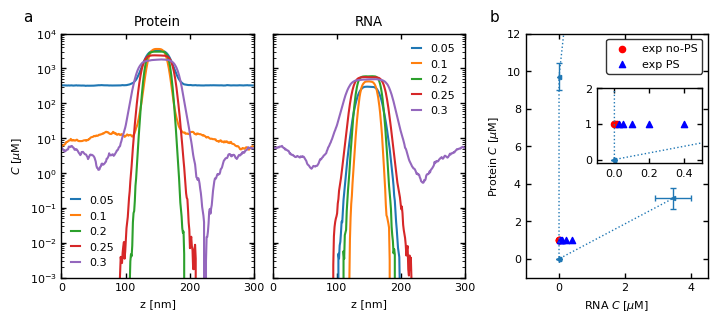

In [15]:
MED1_seq = 626
RNA_seq = 477

systems = {10:[20,400], 20:[20,200], 40:[40,200], 
           50:[50,200], 60:[60,200]}

labels = {10:"0.05", 20:"0.1", 40:"0.2", 
           50:"0.25", 60:"0.3"}
"""
Slab simulation 
"""  
slab_conc = {10:[731.935154,36.596758],
             20:[365.967577,36.596758],
             40:[365.967577,73.193515],
             50:[365.967577,91.491894],
             60:[365.967577,109.790273],
            }

fig, ax = plt.subplots(1,3,figsize=(7,3))
cmap = plt.get_cmap("tab10")

for ind,key in enumerate([10,20,40,50,60]):
    [n_rna, MED1_n]  = systems[key]
    name="MED1-{:d}_RNA-{:d}".format(MED1_n,n_rna)
    print(name)
    data = np.load("./data/view2/PRO_MED1-{:d}_RNA-{:d}.npy".format(MED1_n,n_rna))
    ax[0].plot(data[0],data[1]*1e3,label=labels[key],color=cmap(ind))
    
    data = np.load("./data/view2/RNA_MED1-{:d}_RNA-{:d}.npy".format(MED1_n,n_rna))
    ax[1].plot(data[0],data[1]*1e3,label=labels[key],color=cmap(ind))
    
    data = np.load("./data/view2/MED1{:d}_RNA{:d}.npy".format(MED1_n, n_rna))
    [csat, csat_err, cden, cden_err] = data[0].tolist()
    [csat_r, csat_err_r, cden_r, cden_err_r] = data[1].tolist() 

    
ax[0].legend(fontsize=8,frameon=False,handlelength=0.8)
ax[0].set_xlabel("z [nm]")
ax[0].set_ylabel("$C$ [$\mu$M]")
ax[0].set_title("Protein")
ax[0].set_yscale("log")
ax[0].set_ylim([10**-3,10**4])
ax[0].set_xlim([0,300])

ax[1].legend(fontsize=8,frameon=False,handlelength=0.8)
ax[1].set_xlabel("z [nm]")
ax[1].set_title("RNA")
ax[1].set_yscale("log")
ax[1].set_ylim([10**-3,10**4])
ax[1].set_xlim([0,300])

#=======================
exp_rna = {"nollps":np.array([0,6,12.5]), "llps":np.array([25,50,100,200,400])} # nM
exp_pro = 1# μM

ax3 = fig.add_axes((0.84, 0.5, 0.15,0.25))

protein_csat = []
rna_csat = []
protein_csat_err = []
rna_csat_err = []


for ind,n_rna in enumerate([10,20,40,50,60]):

    data = np.load("./data/view2/MED1{:d}_RNA{:d}.npy".format(MED1_n, n_rna))
    [csat, csat_err, cden, cden_err] = data[0].tolist()
    [csat_r, csat_err_r, cden_r, cden_err_r] = data[1].tolist() 
    print(csat_r)
    protein_csat.append(csat)
    rna_csat.append(csat_r)
    protein_csat_err.append(csat_err)
    rna_csat_err.append(csat_err_r)

protein_csat = np.array(protein_csat)
rna_csat = np.array(rna_csat)
protein_csat_err = np.array(protein_csat_err)
rna_csat_err = np.array(rna_csat_err)
ax[2].errorbar(rna_csat*1e3, protein_csat*1e3, xerr=rna_csat_err*1e3,yerr=protein_csat_err*1e3,marker="<",
               linestyle="dotted", lw=1, ms=3, elinewidth=1, capsize=2, capthick=1)
ax3.errorbar(rna_csat*1e3, protein_csat*1e3, xerr=rna_csat_err*1e3,yerr=protein_csat_err*1e3,marker="<",
               linestyle="dotted", lw=1, ms=3, elinewidth=1, capsize=2, capthick=1)

exp_rna = {"nollps":np.array([0,6,12.5]), "llps":np.array([25,50,100,200,400])} # nM
exp_pro = 1# μM
ax[2].scatter(exp_rna["nollps"]*1e-3, exp_pro*np.ones(len(exp_rna["nollps"])), c="r", label="exp no-PS",s=20,marker="o")
ax[2].scatter(exp_rna["llps"]*1e-3, exp_pro*np.ones(len(exp_rna["llps"])), c="b", label="exp PS",s=20,marker="^")
ax3.scatter(exp_rna["nollps"]*1e-3, exp_pro*np.ones(len(exp_rna["nollps"])), c="r", label="exp no-PS",s=20,marker="o")
ax3.scatter(exp_rna["llps"]*1e-3, exp_pro*np.ones(len(exp_rna["llps"])), c="b", label="exp PS",s=20,marker="^")


ax[2].legend(fontsize=8,edgecolor='black')
#ax[2].set_xlim([0.001,1]) #ax[2].set_xlim([-0.02,0.41])
#ax[2].set_ylim([-0.1,2])
ax[2].set_xlim([-1,4.5]) #ax[2].set_xlim([-0.02,0.41])
ax[2].set_ylim([-1,12])
ax[2].set_ylabel("Protein $C$ [$\mu$M]")
ax[2].set_xlabel("RNA $C$ [$\mu$M]")
#ax[2].set_xscale('log')

ax3.set_xlim([-0.1,0.5]) #ax[2].set_xlim([-0.02,0.41])
ax3.set_ylim([-0.1,2])

plt.setp(ax[1].get_yticklabels(), visible=False)

plt.tight_layout(pad=0.1)

ax_ = ax[0]
pos1 = ax_.get_position()  
pos2 = [pos1.x0, pos1.y0, pos1.width+0.015, pos1.height] 
ax_.set_position(pos2)

ax_ = ax[1]
pos1 = ax_.get_position()  
pos2 = [pos1.x0-0.03, pos1.y0 , pos1.width+0.015, pos1.height] 
ax_.set_position(pos2)

ax[0].text(-0.2, 1.05,"a",fontsize=11,transform=ax[0].transAxes) #ax0.text(-0.18,1.15,"a",fontsize=11,transform=ax0.transAxes)
ax[2].text(-0.2, 1.05,"b",fontsize=11,transform=ax[2].transAxes) #ax4.text(-0.15,0.9,"b",fontsize=11,transform=ax4.transAxes)

plt.savefig("med1_hist.pdf",dpi=300,bbox_inches='tight')
plt.show()

# MED1-RNA-guest

### Plot histogram of MED1 RNA GUEST

In [16]:
def plot_hist_med1_guest(guest_name,n_rna,ax_):
    name="MED1-200_RNA-{:d}_{:s}-{:d}".format(n_rna,guest_name,guest_n)
    
    data = np.load("./data/view2/PRO_MED1-200_RNA-{:d}_{:s}-{:d}.npy".format(n_rna,guest_name,guest_n))
    x0,y0 = data[0], data[1]
    ax_.plot(x0,y0*1e3,label="MED1")         
    
    data = np.load("./data/view2/GUEST_MED1-200_RNA-{:d}_{:s}-{:d}.npy".format(n_rna,guest_name,guest_n))
    x1,y1 = data[0], data[1]
    if guest_name=="STP6":
        ax_.plot(x1,y1*1e3,label="SPT6")
    else:
        ax_.plot(x1,y1*1e3,label=guest_name)
    
    data = np.load("./data/view2/RNA_MED1-200_RNA-{:d}_{:s}-{:d}.npy".format(n_rna,guest_name,guest_n))
    x2,y2 = data[0], data[1]
    ax_.plot(x2,y2*1e3,label="RNA")
    

### Analysis of charge 

In [17]:
def get_charge_plot():
    """
    output
    x0s_plot: RNA/MED1ratio
    y0s_plot: charge in dense
    y0s_err_plot: error of charge in dense
    x1s_plot: RNA/MED1 ratio
    y1s_plot: charge in dliute
    y1s_err_plot: error of charge in dilute
    """
    MED1_seq = 626
    MED1_e = 43
    RNA_seq = 477
    RNA_e = -477

    systems = {10:[20,400], 20:[20,200], 40:[40,200], 
               50:[50,200], 55:[55,200], 60:[60,200]} 
               #70:[70,200], 80:[80,200] }

    x0s_plot, y0s_plot,y0s_err_plot = [], [],[]
    x1s_plot, y1s_plot,y1s_err_plot = [], [],[]
    for ind,key in enumerate([10,20,40,50,60]):
        [n_rna, MED1_n]  = systems[key]
        data = np.load("./data/view2/MED1{:d}_RNA{:d}.npy".format(MED1_n, n_rna))
        [cdil, cdil_err, cden, cden_err] = data[0].tolist()
        [cdil_r, cdil_err_r, cden_r, cden_err_r] = data[1].tolist() 

        charge_den = cden*MED1_e + cden_r*RNA_e
        charge_den_err = np.sqrt( (cden_err*MED1_e)**2 + (cden_err_r*RNA_e)**2 )

        x0s_plot.append(n_rna/MED1_n)
        y0s_plot.append(charge_den)
        y0s_err_plot.append(charge_den_err)


        charge_dil = cdil*MED1_e + cdil_r*RNA_e
        charge_dil_err = cdil_err*MED1_e + cdil_err_r*RNA_e

        x1s_plot.append(n_rna/MED1_n)
        y1s_plot.append(charge_dil)
        y1s_err_plot.append(charge_dil_err)

    x0s_plot, y0s_plot,y0s_err_plot = np.array(x0s_plot), np.array(y0s_plot),np.array(y0s_err_plot)
    x1s_plot, y1s_plot,y1s_err_plot = np.array(x1s_plot), np.array(y1s_plot),np.array(y1s_err_plot)
    return x0s_plot, y0s_plot,y0s_err_plot,x1s_plot, y1s_plot,y1s_err_plot


## Generate figure of sequence 

In [18]:
from IPython.display import HTML

def save_as_html(sequence,fn_save):
    color_dict = {
        'R': 'blue',    # argine
        'K': 'blue',    # lysine
        'H': 'blue',    # histidine
        'D': 'red',   # ASP
        'E': 'red'    # GLU
    }
    
    colored_sequence_list = [
        f"<span style='color: {color_dict[aa]};'>{aa}</span>" if aa in color_dict else aa
        for aa in sequence
    ]

    formatted_sequence = "" 
    line_length = 20

    for i in range(0, len(colored_sequence_list), line_length):
        line = colored_sequence_list[i:i+line_length]
        if len(line) < line_length:
            line += ["&nbsp;" * (line_length - len(line))] 
        formatted_sequence += "".join(line) + "<br>"

    # generate HTML
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Colored Sequence</title>
        <style>
            body {{
                font-family: 'Courier New', monospace; /* equal spacing font*/
                line-height: 1.0; /* modify space betweens lines */
                letter-spacing: 1px; /* modify scape between characters */
                white-space: pre; 
            }}
            .sequence {{
                font-size: 10px; /* fontsize */
            }}
        </style>
    </head>
    <body>
        <p class="sequence">{formatted_sequence}</p>
    </body>
    </html>
    """
    with open(fn_save, "w") as file:
        file.write(html_content)
    return

sequence = "KYKKMKEGENNKPREKSESNKRKSNFSNSADDIKSKKKREQSNDIAR"
save_as_html(sequence,"./h1pa_seq.html")

sequence = "SDFVESEAEESEEEYNDEGEVVPRVTKKFVEEEDDDEEEEEENLDDQDEQGNLKGFINDDDDEDEGEEDEGSDSGDSEDDVGHKKRKRTSFDDRLEDDDFDLIEENLGVKVKRGQKYRRVKKMSDDEDDDEEEYGKEEHEKEAIAEEIFQDGEGEEGQEAMEAPMAPPEEEEEDDEESDIDDFIVDDDGQPLKKPKWRKKL"
save_as_html(sequence,"./stp6_seq.html")

# Figure 5, MED1 simulation

In [19]:
systems = {10:[20,400], 20:[20,200], 40:[40,200], 
           50:[50,200], 55:[55,200], 60:[60,200]}

slab_conc = {10:[731.935154,36.596758],
             20:[365.967577,36.596758],
             40:[365.967577,73.193515],
             50:[365.967577,91.491894],
             55:[365.967577,100.6410835],
             60:[365.967577,109.790273]}

def error_prop(x,y,ex,ey):
    # error propergation x/y
    return np.sqrt( (1/y*ex)**2 + (x/y/y*ey)**2 )

[ 325.51827883 3210.02880656] [  0.         293.06722117]
[   9.70871866 3535.48218741] [  0.         412.68278847]
[   0.         2972.62484477] [  0.         582.84256365]
[   0.         2310.38549609] [  0.         550.14558968]
[   3.22655268 1724.63458583] [  3.45631673 474.14588323]
Dense Charge: [  -1761.82581666  -44823.956043   -150193.03453434 -163072.86994577
 -152008.29910913]
Dilue Charge: [13997.28598976   417.47490241     0.             0.
 -1509.9213168 ]


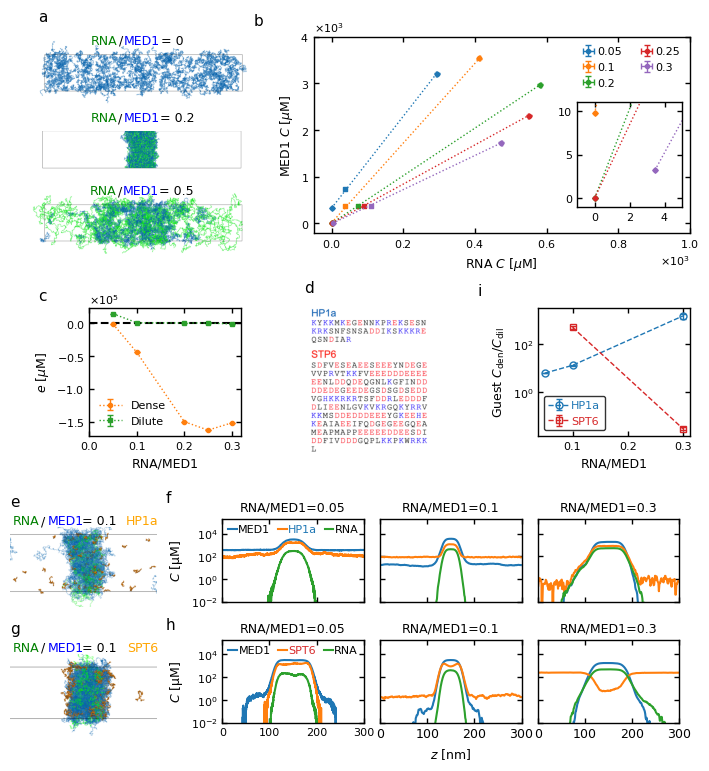

In [20]:
n_fig = 1
fig = plt.figure(figsize=(7*n_fig,7.5*n_fig)) #fig = plt.figure(figsize=(7*n_fig,9.4*n_fig))
ax0 = plt.subplot2grid( (9,6), (0,0), rowspan=1, colspan=2 )
ax1 = plt.subplot2grid( (9,6), (0,2), rowspan=1, colspan=2 )
ax2 = plt.subplot2grid( (9,6), (0,4), rowspan=1, colspan=2 )

ax4 = plt.subplot2grid( (9,6), (0,2), rowspan=3, colspan=4 )
ax5 = fig.add_axes((0.82, 0.75, 0.15,0.14))

ax6 = plt.subplot2grid( (9,6), (5,0), rowspan=2, colspan=2 )
ax7 = plt.subplot2grid( (9,6), (5,2), rowspan=2, colspan=2, sharey=ax6 )
ax8 = plt.subplot2grid( (9,6), (5,4), rowspan=2, colspan=2, sharey=ax6 )

ax9 = plt.subplot2grid( (9,6), (7,0), rowspan=2, colspan=2 )
ax10 = plt.subplot2grid( (9,6), (7,2), rowspan=2, colspan=2, sharey=ax9 )
ax11 = plt.subplot2grid( (9,6), (7,4), rowspan=2, colspan=2, sharey=ax9 )

# middle 
ax12 = plt.subplot2grid( (9,6), (3,0), rowspan=2, colspan=2 )
ax13 = plt.subplot2grid( (9,6), (3,2), rowspan=2, colspan=2 )
ax14 = plt.subplot2grid( (9,6), (3,4), rowspan=2, colspan=2 )

"""
##################################################
"""

for ind,key in enumerate([10,20,40,50,60]): #for ind,key in enumerate([10,20,40,50,55,60]):
    [n_rna, MED1_n]  = systems[key]
    name="MED1-{:d}_RNA-{:d}".format(MED1_n,n_rna) 

    
    data = np.load("./data/view2/MED1{:d}_RNA{:d}.npy".format(MED1_n, n_rna))
    [csat, csat_err, cden, cden_err] = data[0].tolist()
    [csat_r, csat_err_r, cden_r, cden_err_r] = data[1].tolist() 

    pros = np.array([csat,cden])
    rnas = np.array([csat_r,cden_r])
    pro_errs = np.array([csat_err,cden_err])
    rna_errs = np.array([csat_err_r, cden_err_r])
    print(pros*1e3, rnas*1e3)
    ax4.errorbar(rnas*1e3, pros*1e3, xerr=rna_errs*1e3, yerr=pro_errs*1e3, label=n_rna/MED1_n, linestyle="dotted"
                     ,marker='o', lw=1, ms=3, elinewidth=1, capsize=2, capthick=1,color=cmap(ind))

    [slab_pro,slab_rna] = slab_conc[key]
    ax4.scatter(slab_rna,slab_pro,marker="s",color=cmap(ind),s=5)

    ax5.errorbar(rnas*1e3, pros*1e3, xerr=rna_errs, yerr=pro_errs, linestyle="dotted"
                 ,marker='o', lw=1, ms=3, elinewidth=1, capsize=2, capthick=1,color=cmap(ind))

ax4.legend(frameon=False,fontsize=8,handletextpad=0.5,handlelength=0.5,ncol=2,loc="upper right")
ax4.set_xlim([-50,1000])
ax4.set_ylim([-200,4000])
ax4.set_ylabel("MED1 $C$ [$\mu$M]",fontsize=9)
ax4.set_xlabel("RNA $C$ [$\mu$M]",fontsize=9)
ax4.ticklabel_format(style='sci', axis='both', scilimits=(0,0),useMathText=True)
ax4.tick_params(direction='in',labelsize=8)
ax4.xaxis.get_offset_text().set_size(8)
ax4.yaxis.get_offset_text().set_size(8)


ax5.set_xlim([-1.,5]) #ax5.set_xlim([-0.1,1])
ax5.set_ylim([-1.,11]) #ax5.set_ylim([-1,15])
ax5.xaxis.set_label_coords(0.5, -0.15)
ax5.yaxis.set_label_coords(-0.15, 0.5)
ax5.tick_params(direction='in',labelsize=8)
#ax5.xaxis.set_tick_params(pad=-15)


"""
Selective partition: histogram
"""
keys = {10:[400,20,200], 20:[200,20,100], 60:[200,60,100]}

guest_name = 'HP1a'
key = 10
[MED1_n, n_rna, guest_n] = keys[key] 
ax_ = ax6
plot_hist_med1_guest(guest_name, n_rna, ax_)
data = np.load("./data/view2/MED1-{:d}_RNA-{:d}_{:s}-{:d}.npy".format(MED1_n,n_rna,guest_name,guest_n))
csat,csat_err = data[1,0],data[1,1]
cden,cden_err = data[1,2],data[1,3]
ax_.set_title('RNA/MED1={:s}'.format(str(n_rna/MED1_n)[:4]),fontsize=9) 
leg = ax_.legend(frameon=False, handletextpad=0.1,handlelength=0.8,loc='upper center',fontsize=8,ncol=3,columnspacing=0.7,bbox_to_anchor=(0.5, 1.05)) 
text = leg.get_texts()[1]
text.set_color(cmap(0))
ax_.set_yscale('log')
ax_.set_ylabel("$C$ [μM]",fontsize=9)
ax_.set_xlim([0,300])
ax_.set_ylim([2*1e-2,2*1e5])
ax_.tick_params(direction='in',labelsize=8)

guest_name = 'HP1a' 
key = 20
[MED1_n, n_rna, guest_n] = keys[key] 
ax_ = ax7
plot_hist_med1_guest(guest_name, n_rna, ax_)
data = np.load("./data/view2/MED1-{:d}_RNA-{:d}_{:s}-{:d}.npy".format(MED1_n,n_rna,guest_name,guest_n))
csat,csat_err = data[1,0],data[1,1]
cden,cden_err = data[1,2],data[1,3]
ax_.set_title('RNA/MED1={:s}'.format(str(n_rna/MED1_n)[:3]),fontsize=9) 
ax_.set_yscale('log')
ax_.set_xlim([0,300])

guest_name = 'HP1a' 
key = 60
[MED1_n, n_rna, guest_n] = keys[key] 
ax_ = ax8
plot_hist_med1_guest(guest_name, n_rna, ax_)
data = np.load("./data/view2/MED1-{:d}_RNA-{:d}_{:s}-{:d}.npy".format(MED1_n,n_rna,guest_name,guest_n))
csat,csat_err = data[1,0],data[1,1]
cden,cden_err = data[1,2],data[1,3]
ax_.set_title('RNA/MED1={:s}'.format(str(n_rna/MED1_n)[:3]),fontsize=9) #ax_.set_title('RNA/MED1={:d}/{:d}'.format(n_rna,MED1_n))
ax_.set_yscale('log')
ax_.set_xlim([0,300])
ax_.tick_params(direction='in',labelsize=9)

########################################
guest_name = 'STP6'
key = 10
[MED1_n, n_rna, guest_n] = keys[key] 
ax_ = ax9
plot_hist_med1_guest(guest_name, n_rna, ax_)
data = np.load("./data/view2/MED1-{:d}_RNA-{:d}_{:s}-{:d}.npy".format(MED1_n,n_rna,guest_name,guest_n))
csat,csat_err = data[1,0],data[1,1]
cden,cden_err = data[1,2],data[1,3]
ax_.set_title('RNA/MED1={:s}'.format(str(n_rna/MED1_n)[:4]),fontsize=9) #ax_.set_title('RNA/MED1={:d}/{:d}'.format(n_rna,MED1_n))
leg = ax_.legend(frameon=False, handletextpad=0.1, loc='upper center', handlelength=0.8,fontsize=8,ncol=3,columnspacing=0.7,bbox_to_anchor=(0.5, 1.05))
text = leg.get_texts()[1]
text.set_color(cmap(3))
ax_.set_yscale('log')
ax_.set_ylabel("$C$ [μM]",fontsize=9)
ax_.set_xlim([0,300])
ax_.set_ylim([2*1e-2,2*1e5])
ax_.tick_params(direction='in',labelsize=8)

key = 20
[MED1_n, n_rna, guest_n] = keys[key] 
ax_ = ax10
plot_hist_med1_guest(guest_name, n_rna, ax_)
data = np.load("./data/view2/MED1-{:d}_RNA-{:d}_{:s}-{:d}.npy".format(MED1_n,n_rna,guest_name,guest_n))
csat,csat_err = data[1,0],data[1,1]
cden,cden_err = data[1,2],data[1,3]
ax_.set_title('RNA/MED1={:s}'.format(str(n_rna/MED1_n)[:3]),fontsize=9) #ax_.set_title('RNA/MED1={:d}/{:d}'.format(n_rna,MED1_n))
ax_.set_yscale('log')
ax_.set_xlabel("$z$ [nm]",fontsize=9)
ax_.set_xlim([0,300])
ax_.tick_params(direction='in',labelsize=9)

key = 60
[MED1_n, n_rna, guest_n] = keys[key] 
ax_ = ax11
plot_hist_med1_guest(guest_name, n_rna, ax_)
data = np.load("./data/view2/MED1-{:d}_RNA-{:d}_{:s}-{:d}.npy".format(MED1_n,n_rna,guest_name,guest_n))
csat,csat_err = data[1,0],data[1,1]
cden,cden_err = data[1,2],data[1,3]
ax_.set_title('RNA/MED1={:s}'.format(str(n_rna/MED1_n)[:3]),fontsize=9)
ax_.set_yscale('log')
ax_.set_xlim([0,300])
ax_.tick_params(direction='in',labelsize=9)

"""
charge graph
"""
x0s_plot, y0s_plot,y0s_err_plot,x1s_plot, y1s_plot,y1s_err_plot =  get_charge_plot()
ax12.errorbar(x0s_plot, y0s_plot*1e3, yerr=y0s_err_plot, label="Dense", linestyle="dotted"
                 ,marker='o', lw=1, ms=3, elinewidth=1, capsize=2, capthick=1,color=cmap(1))
ax12.set_xlabel("RNA/MED1",fontsize=9)
ax12.set_ylabel("$e$ [$\mu$M]",fontsize=9)
ax12.errorbar(x1s_plot, y1s_plot*1e3, yerr=y1s_err_plot, label="Dilute", linestyle="dotted"
                 ,marker='s', lw=1, ms=3, elinewidth=1, capsize=2, capthick=1,color=cmap(2))
ax12.hlines(0.05,0.32,0,color="k",linestyle="dashed")
ax12.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax12.legend(frameon=False,fontsize=8)
ax12.tick_params(direction='in',labelsize=8)
ax12.ticklabel_format(style='sci', axis='y', scilimits=(5, 5))
ax12.set_xlim([0,0.32])
ax12.yaxis.get_offset_text().set_size(8)
print("Dense Charge:", y0s_plot*1e3)
print("Dilue Charge:", y1s_plot*1e3)


"""
Selective paritioning
"""
HP1a_pro_rna_ratio = []
HP1a_guest_partition = []
HP1a_guest_partition_err = []
STP6_pro_rna_ratio = []
STP6_guest_partition = []
STP6_guest_partition_err = []

guest_name = 'HP1a'
for key in [10,20,60]:
    [MED1_n, n_rna, guest_n] = keys[key] 
    data = np.load("./data/view2/MED1-{:d}_RNA-{:d}_{:s}-{:d}.npy".format(MED1_n,n_rna,guest_name,guest_n))
    csat,csat_err = data[1,0],data[1,1]
    cden,cden_err = data[1,2],data[1,3]
    HP1a_pro_rna_ratio.append(n_rna/MED1_n)
    HP1a_guest_partition.append(cden/csat)
    HP1a_guest_partition_err.append(error_prop(cden,csat,cden_err,csat_err))

    
guest_name = 'STP6'
for key in [10,20,60]:
    [MED1_n, n_rna, guest_n] = keys[key] 
    data = np.load("./data/view2/MED1-{:d}_RNA-{:d}_{:s}-{:d}.npy".format(MED1_n,n_rna,guest_name,guest_n))
    csat,csat_err = data[1,0],data[1,1]
    cden,cden_err = data[1,2],data[1,3]
    STP6_pro_rna_ratio.append(n_rna/MED1_n)
    STP6_guest_partition.append(cden/csat)
    STP6_guest_partition_err.append(error_prop(cden,csat,cden_err,csat_err))


ax14.errorbar(HP1a_pro_rna_ratio,HP1a_guest_partition,yerr=HP1a_guest_partition_err,label="HP1a",
          color=cmap(0),marker="o",linestyle="dashed", lw=1, ms=5, elinewidth=1, capsize=2, capthick=1, markerfacecolor="none")
ax14.errorbar(STP6_pro_rna_ratio,STP6_guest_partition,yerr=STP6_guest_partition_err,label="SPT6",
          color=cmap(3),marker="s",linestyle="dashed", lw=1, ms=5, elinewidth=1, capsize=2, capthick=1, markerfacecolor="none")
leg = ax14.legend(handletextpad=0.1,edgecolor='black',fontsize=8) #ax13.legend(frameon=False)
for line,text in zip(leg.legendHandles, leg.get_texts()): # change the font colors to match the line colors:
    try:
        col = line.get_color()
    except:
        col = line.get_facecolor()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
ax14.set_yscale("log")
ax14.set_xlabel("RNA/MED1",fontsize=9)
ax14.set_ylabel("Guest $C_{\mathrm{den}}/C_{\mathrm{dil}}$",fontsize=9)
ax14.tick_params(direction='in',labelsize=8)


ax0.axis('off')
#ax0 = fig.add_axes((0.06, 0.86, 0.3,0.14))
ax0 = fig.add_axes((0.01+0.04, 0.86, 0.3,0.14))
ax0.axis("off")
ax0.imshow(Image.open("./data/view2_fig_snapshot/MED1-200_RNA-0.png"))
ax0.text(0.38, 1.1, 'RNA', color='green', fontsize=9, ha='right', va='top', transform=ax0.transAxes)
ax0.text(0.395, 1.1, '/', color='black', fontsize=9, ha='center', va='top', transform=ax0.transAxes)
ax0.text(0.41, 1.1, 'MED1', color='blue', fontsize=9, ha='left', va='top', transform=ax0.transAxes)
ax0.text(0.62, 1.1, '  = 0', color='black', fontsize=9, ha='center', va='top', transform=ax0.transAxes)
#ax0.text(0.25,1.05,"RNA/MED1=0/200",fontsize=9,transform=ax0.transAxes)

ax1.axis('off')
alpha = 0.95
ax1 = fig.add_axes((0.015+0.04, 0.77, 0.3*alpha,0.14*alpha))
ax1.axis("off")
ax1.imshow(Image.open("./data/view2_fig_snapshot/MED1-200_RNA-40.png")) 
ax1.text(0.38, 1.5, 'RNA', color='green', fontsize=9, ha='right', va='top', transform=ax1.transAxes)
ax1.text(0.395, 1.5, '/', color='black', fontsize=9, ha='center', va='top', transform=ax1.transAxes)
ax1.text(0.41, 1.5, 'MED1', color='blue', fontsize=9, ha='left', va='top', transform=ax1.transAxes)
ax1.text(0.66, 1.5, '  = 0.2', color='black', fontsize=9, ha='center', va='top', transform=ax1.transAxes)

ax2.axis('off')
alpha = 1.02
ax2 = fig.add_axes((0.0+0.04, 0.67, 0.3*alpha,0.14*alpha))
ax2.axis("off")
ax2.imshow(Image.open("./data/view2_fig_snapshot/MED1-200_RNA-100.png")) 
ax2.text(0.40, 1.05, 'RNA', color='green', fontsize=9, ha='right', va='top', transform=ax2.transAxes)
ax2.text(0.415, 1.05, '/', color='black', fontsize=9, ha='center', va='top', transform=ax2.transAxes)
ax2.text(0.43, 1.05, 'MED1', color='blue', fontsize=9, ha='left', va='top', transform=ax2.transAxes)
ax2.text(0.68, 1.05, '= 0.5', color='black', fontsize=9, ha='center', va='top', transform=ax2.transAxes)

ax13.axis('off')
ax13 = fig.add_axes((0.41,0.46,0.22,0.20))
ax13.axis('off')
ax13.imshow(Image.open("./data/view2_fig_snapshot/seq_hp1a_stp6.png"))  #ax13.imshow(Image.open("fig_snapshot/MED1-200_RNA-20_HP1a-100.png")) 

a_text = ax0.text(0,1.3,"a",fontsize=11,transform=ax0.transAxes) #ax0.text(-0.18,1.15,"a",fontsize=11,transform=ax0.transAxes)
b_text = ax4.text(-0.2,1,"b",fontsize=11,transform=ax4.transAxes) #ax4.text(-0.15,0.9,"b",fontsize=11,transform=ax4.transAxes)
c_text = ax12.text(-0.5,1,"c",fontsize=11,transform=ax12.transAxes) #ax12.text(0.,1.8,"e",fontsize=11,transform=ax12.transAxes)
d_text = ax13.text(-0,1,"d",fontsize=11,transform=ax13.transAxes) #ax13.text(-0.2,0.9,"f",fontsize=11,transform=ax13.transAxes)
g_text = ax14.text(-0.4,1,"i",fontsize=11,transform=ax14.transAxes) 

plt.setp(ax6.get_xticklabels(), visible=False)
plt.setp(ax7.get_xticklabels(), visible=False)
plt.setp(ax7.get_yticklabels(), visible=False)
plt.setp(ax8.get_xticklabels(), visible=False)
plt.setp(ax8.get_yticklabels(), visible=False)

plt.setp(ax10.get_yticklabels(), visible=False)
plt.setp(ax11.get_yticklabels(), visible=False)


plt.tight_layout(pad=0.1)

for ax__ in [ax12,ax13,ax14]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0 , pos1.y0 - 0.05, pos1.width, pos1.height+0.02] 
    ax__.set_position(pos2)

for ax__ in [ax6,ax7,ax8]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0, pos1.y0 - 0.05, pos1.width, pos1.height] 
    ax__.set_position(pos2)
    
for ax__ in [ax9,ax10,ax11]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0 , pos1.y0 + 0.01, pos1.width, pos1.height] 
    ax__.set_position(pos2)

for ax__ in [ax6,ax7,ax8,ax9,ax10,ax11]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0, pos1.y0, pos1.width-0.015, pos1.height-0.04] 
    ax__.set_position(pos2)  
    
for ax__ in [ax7,ax10]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0+0.095, pos1.y0, pos1.width, pos1.height] 
    ax__.set_position(pos2) 
    
for ax__ in [ax6,ax9]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0+0.19, pos1.y0, pos1.width, pos1.height] 
    ax__.set_position(pos2) 

ax15 = fig.add_axes((0.01, 0.2, 0.21,0.14))
ax15.axis('off')
ax15.imshow(Image.open("./data/view2_fig_snapshot/med1-200_rna-20_hp1a-100.png"))
ax15.text(0.2, 1.15, 'RNA', color='green', fontsize=9, ha='right', va='top', transform=ax15.transAxes) #ax15.text(0.6, 1.1, 'RNA', color='green', fontsize=9, ha='right', va='top', transform=ax15.transAxes)
ax15.text(0.225, 1.15, '/', color='black', fontsize=9, ha='center', va='top', transform=ax15.transAxes)
ax15.text(0.26, 1.15, 'MED1', color='blue', fontsize=9, ha='left', va='top', transform=ax15.transAxes) #ax15.text(0.1, 1.1, 'MED1', color='blue', fontsize=9, ha='left', va='top', transform=ax15.transAxes)
ax15.text(0.58, 1.15, '  = 0.1', color='black', fontsize=9, ha='center', va='top', transform=ax15.transAxes)
ax15.text(0.9, 1.15, 'HP1a', color='orange', fontsize=9, ha='center', va='top', transform=ax15.transAxes)


ax16 = fig.add_axes((0.01, 0.03, 0.21,0.14))
ax16.axis('off')
ax16.imshow(Image.open("./data/view2_fig_snapshot/med1-200_rna-20_stp6-100.png"))
ax16.text(0.2, 1.15, 'RNA', color='green', fontsize=9, ha='right', va='top', transform=ax16.transAxes) #ax15.text(0.6, 1.1, 'RNA', color='green', fontsize=9, ha='right', va='top', transform=ax15.transAxes)
ax16.text(0.225, 1.15, '/', color='black', fontsize=9, ha='center', va='top', transform=ax16.transAxes)
ax16.text(0.26, 1.15, 'MED1', color='blue', fontsize=9, ha='left', va='top', transform=ax16.transAxes) #ax15.text(0.1, 1.1, 'MED1', color='blue', fontsize=9, ha='left', va='top', transform=ax15.transAxes)
ax16.text(0.58, 1.15, '  = 0.1', color='black', fontsize=9, ha='center', va='top', transform=ax16.transAxes)
ax16.text(0.9, 1.15, 'SPT6', color='orange', fontsize=9, ha='center', va='top', transform=ax16.transAxes)

"""
minor modification
"""
#snap shots of RNA/MED system
for ax__ in [ax1,ax2]:
    pos1 = ax__.get_position()  
    pos2 = [pos1.x0, pos1.y0-0.01, pos1.width, pos1.height] 
    ax__.set_position(pos2) 

# characters for labeling
pos1 =  b_text.get_position()    
pos2 = (pos1[0]+0.04, pos1[1]+0.06)
b_text.set_position(pos2)

pos1 =  c_text.get_position()    
pos2 = (pos1[0]+0.16, pos1[1]+0.06)
c_text.set_position(pos2)

pos1 =  d_text.get_position()    
pos2 = (pos1[0], pos1[1]+0.08)
d_text.set_position(pos2)

pos1 =  g_text.get_position()    
pos2 = (pos1[0], pos1[1]+0.04)
g_text.set_position(pos2)

pos1 =  g_text.get_position()    
pos2 = (pos1[0], pos1[1]+0.06)
g_text.set_position(pos2)

ax15.text(0,1.25,"e",fontsize=11,transform=ax15.transAxes) 
ax6.text(-0.4,1.2,"f",fontsize=11,transform=ax6.transAxes) 
ax16.text(0,1.25,"g",fontsize=11,transform=ax16.transAxes) 
ax9.text(-0.4,1.12,"h",fontsize=11,transform=ax9.transAxes) 
#b_text = ax4.text(-0.2,1,"b",fontsize=11,transform=ax4.transAxes) #ax4.text(-0.15,0.9,"b",fontsize=11,transform=ax4.transAxes)
#ax6.text(-2,1,"e",fontsize=11,transform=ax6.transAxes) #ax6.text(-0.35,1.05,"c",fontsize=11,transform=ax6.transAxes)
#ax9.text(-2,1,"f",fontsize=11,transform=ax9.transAxes) #ax9.text(-0.35,1,"d",fontsize=11,transform=ax9.transAxes)
#c_text = ax12.text(-0.5,1,"c",fontsize=11,transform=ax12.transAxes) #ax12.text(0.,1.8,"e",fontsize=11,transform=ax12.transAxes)
#d_text = ax13.text(-0,1,"d",fontsize=11,transform=ax13.transAxes) #ax13.text(-0.2,0.9,"f",fontsize=11,transform=ax13.transAxes)
#g_text = ax14.text(-0.4,1,"g",fontsize=11,transform=ax14.transAxes) 

ax6.set_yticks([10**-2,10**0, 10**2, 10**4])
formatter = ticker.LogFormatterMathtext(base=10)
ax6.yaxis.set_major_formatter(formatter)

ax9.set_yticks([10**-2,10**0, 10**2, 10**4])
formatter = ticker.LogFormatterMathtext(base=10)
ax9.yaxis.set_major_formatter(formatter)

plt.savefig("figure5.pdf",dpi=300,bbox_inches='tight')
plt.show()

# Sequence analysis

In [21]:
SPT6_fasta='SDFVESEAEESEEEYNDEGEVVPRVTKKFVEEEDDDEEEEEENLDDQDEQGNLKGFINDDDDEDEGEEDEGSDSGDSEDDVGHKKRKRTSFDDRLEDDDFDLIEENLGVKVKRGQKYRRVKKMSDDEDDDEEEYGKEEHEKEAIAEEIFQDGEGEEGQEAMEAPMAPPEEEEEDDEESDIDDFIVDDDGQPLKKPKWRKKL'
HP1a_fasta='KYKKMKEGENNKPREKSESNKRKSNFSNSADDIKSKKKREQSNDIAR'
PLP_fasta='MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNSYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGG'
FUSRRG_fasta='RRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGC'
MED1_fasta = 'EHHSGSQGPLLTTGDLGKEKTQKRVKEGNGTSNSTLSGPGLDSKPGKRSRTPSNDGKSKDKPPKRKKADTEGKSPSHSSSNRPFTPPTSTGGSKSPGSAGRSQTPPGVATPPIPKITIQIPKGTVMVGKPSSHSQYTSSGSVSSSGSKSHHSHSSSSSSSASTSGKMKSSKSEGSSSSKLSSSMYSSQGSSGSSQSKNSSQSGGKPGSSPITKHGLSSGSSSTKMKPQGKPSSLMNPSLSKPNISPSHSRPPGGSDKLASPMKPVPGTPPSSKAKSPISSGSGGSHMSGTSSSSGMKSSSGLGSSGSLSQKTPPSSNSCTASSSSFSSSGSSMSSSQNQHGSSKGKSPSRNKKPSLTAVIDKLKHGVVTSGPGGEDPLDGQMGVSTNSSSHPMSSKHNMSGGEFQGKREKSDKDKSKVSTSGSSVDSSKKTSESKNVGSTGVAKIIISKHDGGSPSIKAKVTLQKPGESSGEGLRPQMASSKNYGSPLISGSTPKHERGSPSHSKSPAYTPQNLDSESESGSSIAEKSYQNSPSSDDGIRPLPEYSTEKHKKHKKEKKKVKDKDRDRDRDKDRDKKKSHSIKPESWSKSPISSDQSLSMTSNTILSADRPSRLSPDFMIGEEDDDL'
def get_protein_charge(fasta):
    f = './data/residues.csv'
    residues = pd.read_csv(f).set_index('one')
    qs = []
    for a in list(fasta):
        if a in ['a','u','r']: # for RNA
            qs.append(residues.loc['p','q'])
            qs.append(residues.loc[a,'q'])
        else:
            qs.append(residues.loc[a,'q'])
    print("length",len(qs))
    return np.array(qs).sum()

print("PLP", get_protein_charge(PLP_fasta))
print("FUSRRG", get_protein_charge(FUSRRG_fasta))
print("SPT6", get_protein_charge(SPT6_fasta))
print("HP1a", get_protein_charge(HP1a_fasta))
print("MED1", get_protein_charge(MED1_fasta))



length 173
PLP -2
length 34
FUSRRG 7
length 201
SPT6 -62
length 47
HP1a 8
length 626
MED1 43
